This notebook does basic return regressions.

The idea is to establish a baseline expectation for how previous returns affect future returns.  This is a first step down the momentum vs mean reversion rabbit hole.

The predicted variable is the 1D (log) return, with predictors of 1D, 5D, 20D, 60D, 250D, 500D, 1000D (dailyized log) returns.  The analysis is performed on both absolute and relative (to SPY) returns.

It seems unlikely that doing a per stock regression would be a fruitful exercise; theoretically, stocks could systematically behave differently, but also markets can dynamically change behavior towards a single stock.  Estimation issues abound.  Here the particular stock is not a feature and all data points are treated equally.

This regression is done using a simple linear model in pytorch with absolute error minimization.  No more complicated model is desired at this point.

In [2]:
from datasets import RetDataset
from torch.utils.data import DataLoader

import torch
from torch import nn
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

In [11]:
years = range(2018,2023)
#fns = [f'data/{y}_RET.csv' for y in years]
fns = [f'data/{y}_RELRET.csv' for y in years]
print(fns)

ds = RetDataset(fns)
print (len(ds))

print(ds[0])

['data/2018_RELRET.csv', 'data/2019_RELRET.csv', 'data/2020_RELRET.csv', 'data/2021_RELRET.csv', 'data/2022_RELRET.csv']
599564
{'features': array([-0.00709536, -0.006178  , -0.00137093,  0.0007246 ,  0.00081407,
        0.00044449,  0.00042313], dtype=float32), 'target': array([0.01061435], dtype=float32)}


starting epoch 0


100%|██████████| 2343/2343 [02:12<00:00, 17.73it/s]


weight tensor([[ 9.4069e-03, -3.2364e-02, -1.2725e-04, -1.6614e-02,  1.4312e-01,
          1.0869e-01,  7.9908e-02]])


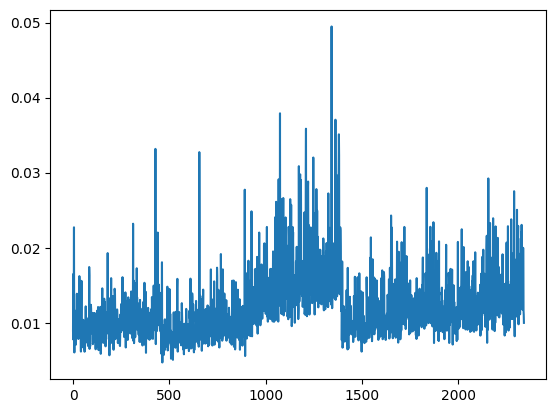

starting epoch 1


100%|██████████| 2343/2343 [02:17<00:00, 17.07it/s]


weight tensor([[ 0.0093, -0.0323,  0.0019, -0.0246,  0.1607,  0.1104,  0.0702]])


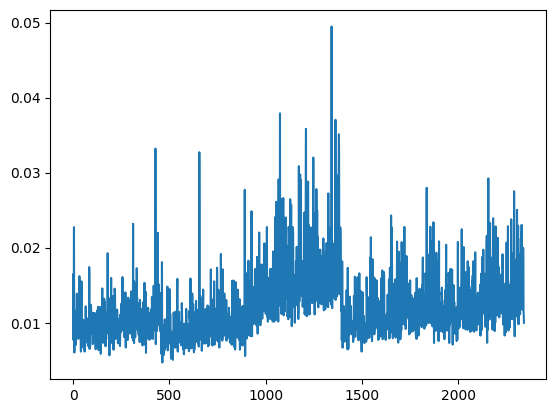

starting epoch 2


100%|██████████| 2343/2343 [02:26<00:00, 16.03it/s]


weight tensor([[ 0.0094, -0.0326,  0.0025, -0.0267,  0.1660,  0.1088,  0.0654]])


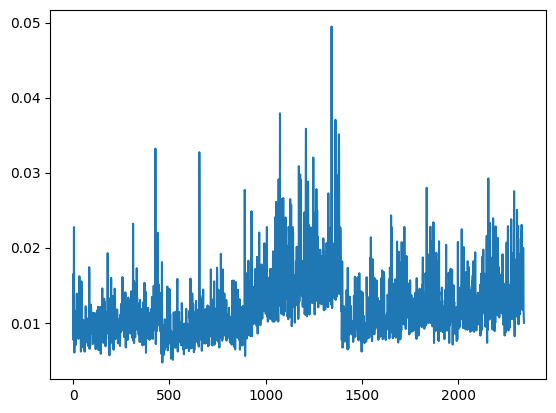

starting epoch 3


100%|██████████| 2343/2343 [02:29<00:00, 15.63it/s]


weight tensor([[ 0.0093, -0.0326,  0.0027, -0.0274,  0.1679,  0.1078,  0.0636]])


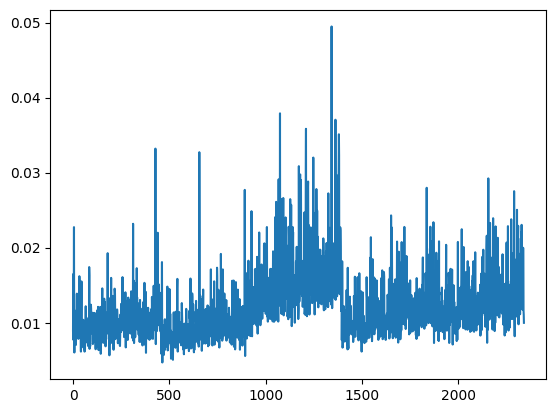

starting epoch 4


100%|██████████| 2343/2343 [02:21<00:00, 16.60it/s]


weight tensor([[ 0.0093, -0.0326,  0.0031, -0.0278,  0.1694,  0.1075,  0.0629]])


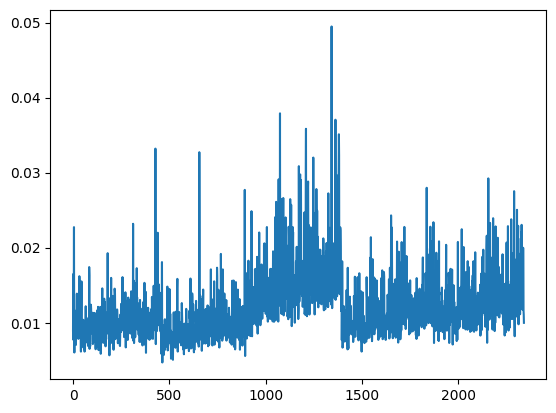

starting epoch 5


100%|██████████| 2343/2343 [02:24<00:00, 16.26it/s]


weight tensor([[ 0.0092, -0.0327,  0.0029, -0.0281,  0.1699,  0.1070,  0.0627]])


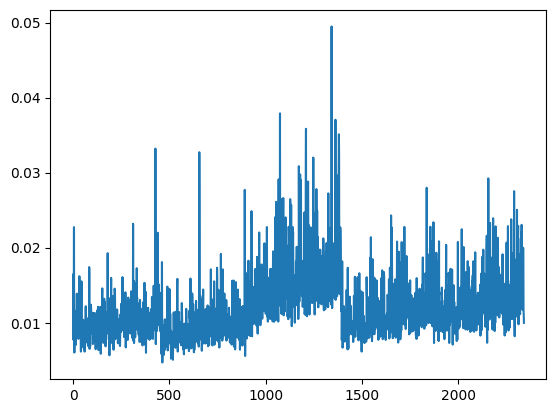

starting epoch 6


100%|██████████| 2343/2343 [02:28<00:00, 15.77it/s]


weight tensor([[ 0.0093, -0.0329,  0.0029, -0.0277,  0.1697,  0.1068,  0.0626]])


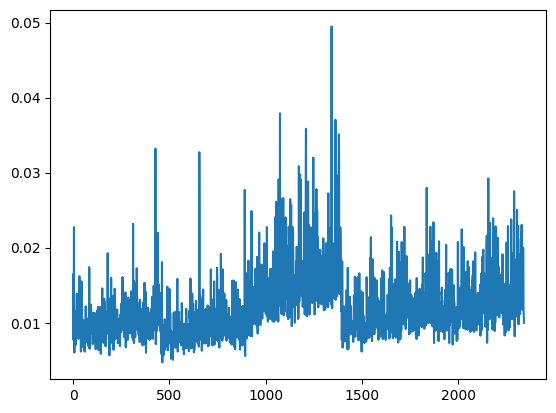

starting epoch 7


100%|██████████| 2343/2343 [02:25<00:00, 16.07it/s]


weight tensor([[ 0.0093, -0.0328,  0.0029, -0.0281,  0.1702,  0.1069,  0.0626]])


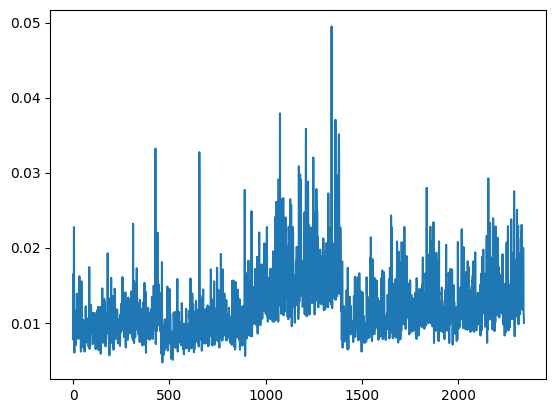

starting epoch 8


100%|██████████| 2343/2343 [02:33<00:00, 15.29it/s]


weight tensor([[ 0.0092, -0.0327,  0.0030, -0.0281,  0.1703,  0.1069,  0.0628]])


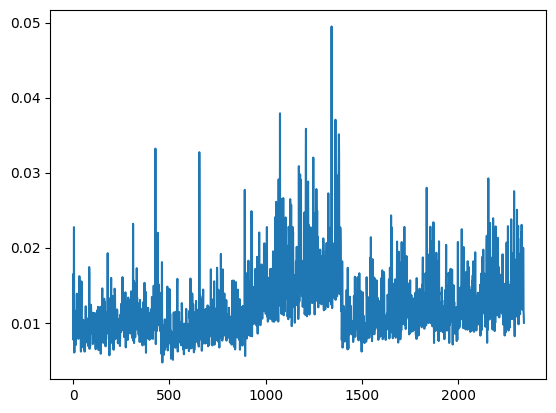

starting epoch 9


100%|██████████| 2343/2343 [02:08<00:00, 18.21it/s]


weight tensor([[ 0.0093, -0.0327,  0.0026, -0.0277,  0.1706,  0.1069,  0.0626]])


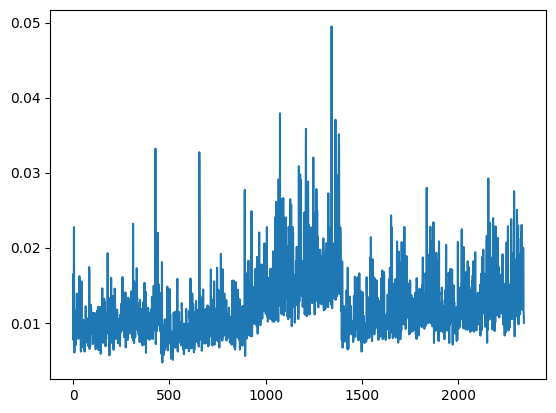

In [12]:
ldr = DataLoader(ds,batch_size=256)

mod = nn.Linear(7,1,bias=False)
nn.init.zeros_(mod.weight)

#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

learning_rate = 1e-3
weight_decay = 1e-5
optimizer = torch.optim.Adam(mod.parameters(), lr=learning_rate, weight_decay=weight_decay)

for ep in range(10):
    print(f'starting epoch {ep}')
    losses = []
    for dat in tqdm(ldr):
        xs = dat['features']
        ys = dat['target']
        yp = mod.forward(xs)
        loss = loss_fn(yp,ys)
        #print(loss.item())
        losses.append(loss.item())
                
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    for name, param in mod.named_parameters():
        if param.requires_grad:
            print (name, param.data)

    plt.plot(losses)
    plt.show()



In [13]:


ABS return runs (2018-2022)

weight tensor([[ 0.0426, -0.0938,  0.0360, -0.1949,  0.1119,  0.0899,  0.4502]])
weight tensor([[ 0.0425, -0.0901,  0.0371, -0.2073,  0.0892, -0.0877,  0.9338]])


SyntaxError: invalid syntax (3527011045.py, line 1)

Returns - 1D, 5D, 20D, 60D, 250D, 500D, 1000D

-Absolute return run (2018-2022)

weight tensor([[ 0.0425, -0.0901,  0.0371, -0.2073,  0.0892, -0.0877,  0.9338]])

-Relative return run (2018-2022)
weight tensor([[ 0.0093, -0.0327,  0.0026, -0.0277,  0.1706,  0.1069,  0.0626]])

In both cases, the biggest sensitivites are to maturities >= 1y.  Interestingly, absolute returns have some seeming mean reversion at 5D and 60D horizons, while relative returns are much less pronounced.

In [34]:
from datasets import RetDataset
years = range(2018,2023)
fns = [f'data/{y}_RET.csv' for y in years]
#fns = [f'data/{y}_RELRET.csv' for y in years]

#ds = RetDataset(fns,subsets=['Ret','Ret250D'])
ds = RetDataset(fns,subsets=['Ret','Ret5D'])
print (len(ds))

print(ds[0])




599564
{'features': array([-0.0067169], dtype=float32), 'target': array([0.01774641], dtype=float32)}


starting epoch 0


100%|██████████| 2343/2343 [01:45<00:00, 22.17it/s]


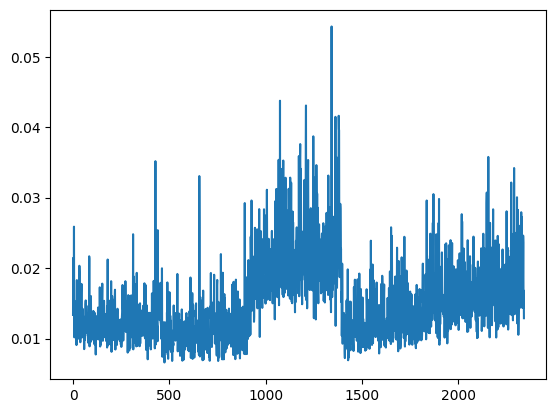

starting epoch 1


100%|██████████| 2343/2343 [01:49<00:00, 21.40it/s]


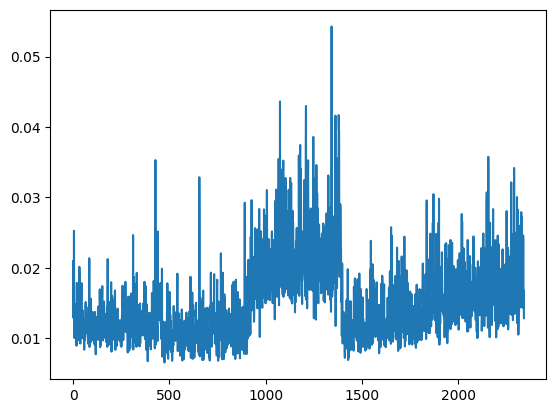

starting epoch 2


100%|██████████| 2343/2343 [01:49<00:00, 21.36it/s]


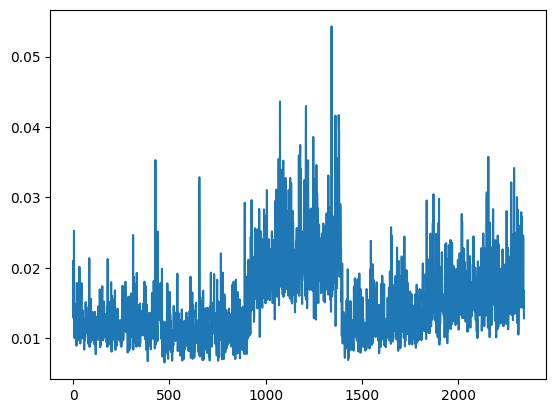

In [35]:
ldr = DataLoader(ds,batch_size=256)

class SimpleFF(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1,1,bias=False)
        self.tanh = nn.Tanh()
        self.lin2 = nn.Linear(1,1,bias=False)

    def forward(self, inputs):
        outputs = self.lin2(self.tanh(self.lin1(inputs)))
        return outputs
    

mod = SimpleFF()

#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

learning_rate = 1e-3
weight_decay = 1e-5
optimizer = torch.optim.Adam(mod.parameters(), lr=learning_rate, weight_decay=weight_decay)

for ep in range(3):
    print(f'starting epoch {ep}')
    losses = []
    for dat in tqdm(ldr):
        xs = dat['features']
        ys = dat['target']
        #print(xs[0],ys[0])

        yp = mod.forward(xs)
        loss = loss_fn(yp,ys)
        #print(loss.item())
        losses.append(loss.item())
                
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    plt.plot(losses)
    plt.show()




Parameter containing:
tensor([[0.0547]], requires_grad=True)
Parameter containing:
tensor([[0.3474]], requires_grad=True)
tensor([-0.0100, -0.0089, -0.0079, -0.0068, -0.0058, -0.0047, -0.0037, -0.0026,
        -0.0016, -0.0005,  0.0005,  0.0016,  0.0026,  0.0037,  0.0047,  0.0058,
         0.0068,  0.0079,  0.0089,  0.0100]) [-1.8989439e-04 -1.6990551e-04 -1.4991662e-04 -1.2992775e-04
 -1.0993887e-04 -8.9949986e-05 -6.9961097e-05 -4.9972215e-05
 -2.9983330e-05 -9.9944418e-06  9.9944418e-06  2.9983330e-05
  4.9972215e-05  6.9961097e-05  8.9949986e-05  1.0993887e-04
  1.2992775e-04  1.4991662e-04  1.6990551e-04  1.8989439e-04]
slope:0.0189894400537014


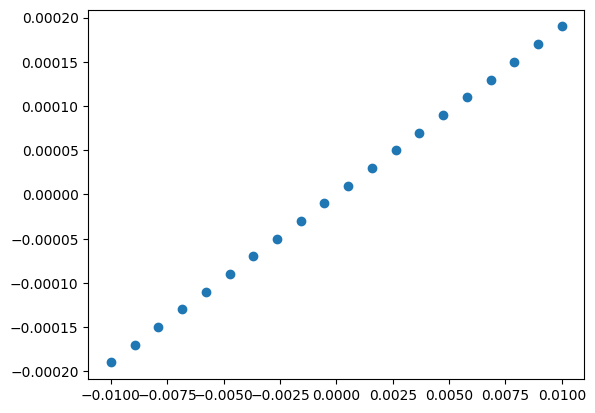

In [33]:
print(mod.lin1.weight)
print(mod.lin2.weight)

x = np.linspace(-.01,.01,20)
x = torch.Tensor(x)
xt = x.reshape((20,1))
#print(x.shape)
yt = mod.forward(xt)
y = yt.reshape((20,)).detach().numpy()
print(x,y)

plt.scatter(x,y)

slope = (y[10]-y[9])/(x[10]-x[9])
print(f'slope:{slope}')


For relative returns at the 250D horizon the tanh doesn't learn much in the way of shape.  The sensitivity is roughly 20%, not far from the multivariate linear regression.

Relative
250D - 18.75%
1D - 1.9%
